Enter your SentinelHub client id:  ········
Enter your SentinelHub client secret:  ········



Processing shapefile: NUTS_NL_01m_2024.shp


/tmp/ipykernel_18884/2609098206.py:121: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons_gdf["area"] = polygons_gdf.geometry.area
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


  Building requests for year 2018...
  Building requests for year 2019...
  Building requests for year 2020...
  Building requests for year 2021...
  Building requests for year 2022...
  Building requests for year 2023...

Processing shapefile: NUTS_SL_01m_2024.shp
  Building requests for year 2018...


/tmp/ipykernel_18884/2609098206.py:121: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons_gdf["area"] = polygons_gdf.geometry.area
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


  Building requests for year 2019...
  Building requests for year 2020...
  Building requests for year 2021...
  Building requests for year 2022...
  Building requests for year 2023...



/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarni


✅ O3 data successfully saved to O3_all_years_two_shapefiles.csv


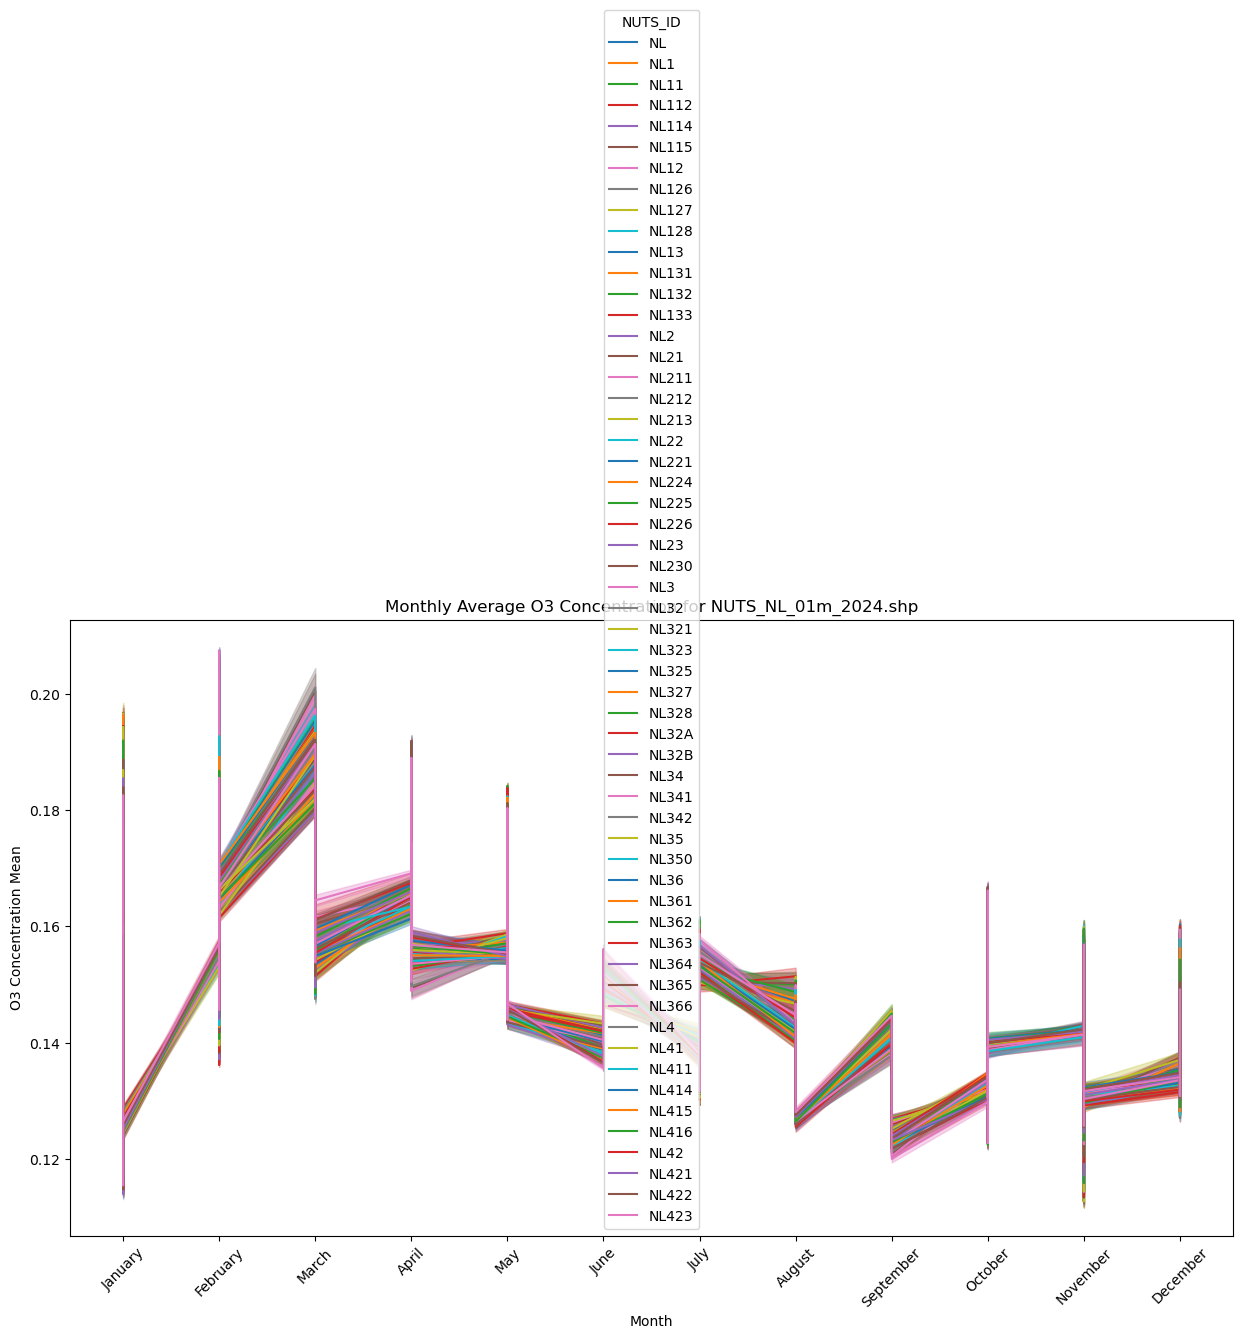

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as cx
import calendar
import getpass
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    CRS,
    Geometry,
    parse_time,
)

# =============================================================================
# Helper Function: Convert API response into a DataFrame
# =============================================================================
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame."""
    df_data = []
    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True
        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()
        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break
                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value
            if not is_valid_entry:
                break
        if is_valid_entry:
            df_data.append(df_entry)
    return pd.DataFrame(df_data)

# =============================================================================
# Define the O3 evalscript for the Statistical API
# =============================================================================
o3_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["O3", "dataMask"],
    output: [
      {
        id: "o3",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  };
}

function evaluatePixel(sample) {
  return {
    o3: [sample.O3],
    dataMask: [sample.dataMask]
  };
}
"""

# =============================================================================
# Set Up Sentinel Hub Configuration
# =============================================================================
config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    config.sh_client_id = getpass.getpass("Enter your SentinelHub client id: ")
    config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret: ")
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    config.save("cdse")
config = SHConfig("cdse")

# =============================================================================
# Prepare the Sentinel-5P Input Data for O3
# =============================================================================
input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL5P.define_from("s5p", service_url=config.sh_base_url)
)

# =============================================================================
# Specify the shapefiles and years to process
# =============================================================================
shapefile_paths = [
    "NUTS_NL_01m_2024.shp",     # First shapefile
    "NUTS_SL_01m_2024.shp"      # Second shapefile (change filename as needed)
]
years = range(2018, 2024)  # Process from 2018 to 2024

# Lists to store all requests and their metadata
o3_requests = []
request_info = []

# =============================================================================
# Build Requests for Each Shapefile, Year, and Month (for O3)
# =============================================================================
for shp_path in shapefile_paths:
    print(f"\nProcessing shapefile: {shp_path}")
    polygons_gdf = gpd.read_file(shp_path)
    # Ensure CRS is WGS84
    if polygons_gdf.crs.to_string() != "EPSG:4326":
        polygons_gdf = polygons_gdf.to_crs(epsg=4326)
    # Optional: add an area column
    polygons_gdf["area"] = polygons_gdf.geometry.area

    for year in years:
        print(f"  Building requests for year {year}...")
        for idx, row in polygons_gdf.iterrows():
            # Use a unique identifier (e.g., "NUTS_ID" if available, otherwise use idx)
            nuts_id = row["NUTS_ID"] if "NUTS_ID" in row else f"poly_{idx}"
            geom = row.geometry
            for month in range(1, 13):
                start_date = pd.Timestamp(year, month, 1)
                # Define end date: first day of next month (or next year if December)
                if month == 12:
                    end_date = pd.Timestamp(year + 1, 1, 1)
                else:
                    end_date = pd.Timestamp(year, month + 1, 1)
                aggregation = SentinelHubStatistical.aggregation(
                    evalscript=o3_evalscript,
                    time_interval=(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")),
                    aggregation_interval="P1M"
                )
                request = SentinelHubStatistical(
                    aggregation=aggregation,
                    input_data=[input_data],
                    geometry=Geometry(geom, crs=CRS(polygons_gdf.crs)),
                    config=config,
                )
                o3_requests.append(request)
                request_info.append({
                    "shapefile": os.path.basename(shp_path),
                    "NUTS_ID": nuts_id,
                    "year": year,
                    "month": start_date.strftime("%B"),
                    "month_num": month
                })

# =============================================================================
# Download the Statistical Data for All Requests
# =============================================================================
print("\nDownloading O3 data for all years and shapefiles...")
client = SentinelHubStatisticalDownloadClient(config=config)
download_requests = [req.download_list[0] for req in o3_requests]
o3_stats = client.download(download_requests)

# =============================================================================
# Process the Downloaded Statistics and Build a DataFrame
# =============================================================================
o3_dfs = []
for stats, info in zip(o3_stats, request_info):
    df = stats_to_df(stats)
    if not df.empty:
        df["shapefile"] = info["shapefile"]
        df["NUTS_ID"] = info["NUTS_ID"]
        df["year"] = info["year"]
        df["month"] = info["month"]
        df["month_num"] = info["month_num"]
        o3_dfs.append(df)

if o3_dfs:
    o3_df = pd.concat(o3_dfs, ignore_index=True)
    o3_df.sort_values(by=["shapefile", "NUTS_ID", "year", "month_num"], inplace=True)
else:
    o3_df = pd.DataFrame()

# =============================================================================
# Save the Combined Data to CSV
# =============================================================================
output_csv = "O3_all_years_two_shapefiles.csv"
o3_df.to_csv(output_csv, index=False)
print(f"\n✅ O3 data successfully saved to {output_csv}")

# =============================================================================
# (Optional) Plot Example: Monthly O3 Time Series for a Single Shapefile
# =============================================================================
example_shp = os.path.basename(shapefile_paths[0])
example_df = o3_df[o3_df["shapefile"] == example_shp]

month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xlabel("Month")
ax.set_ylabel("O3 Concentration Mean")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_order, rotation=45)

# Plot each unique polygon's time series
for idx, nuts_id in enumerate(example_df["NUTS_ID"].unique()):
    series = example_df[example_df["NUTS_ID"] == nuts_id].sort_values("month_num")
    ax.plot(series["month_num"], series["o3_B0_mean"], color=f"C{idx}", label=str(nuts_id))
    ax.fill_between(
        series["month_num"],
        series["o3_B0_mean"] - series["o3_B0_stDev"],
        series["o3_B0_mean"] + series["o3_B0_stDev"],
        color=f"C{idx}",
        alpha=0.3,
    )

ax.legend(title="NUTS_ID")
plt.title(f"Monthly Average O3 Concentration for {example_shp}")
plt.show()
